In [1]:
from matplotlib import pyplot as plt
import numpy as np

plt.rc('axes', titlesize=10) #fontsize of the title

In [2]:
from utils import load_ecg
from preprocessing.data_processing import normalize
from heartpy import remove_baseline_wander, enhance_ecg_peaks

In [3]:
fs = 300
T = 1/fs
N = signal.shape[0]
t = np.arange(0, int(N * T), T)

NameError: name 'signal' is not defined

In [59]:
signal = load_ecg("/home/aateg/workspace/tud/wettbewerb/training/train_ecg_05610.mat")

In [20]:
signal.shape

(12540,)

In [39]:
fs = 300
T = 1/fs
N = signal.shape[0]
t = np.linspace(0, N*T, N)

In [41]:
t.shape

(12540,)

In [36]:
t.shape

(12300,)

In [42]:
def plot_ecg(signal):
    
    plt.figure(figsize=(20,10))
    fs = 300
    T = 1/fs
    N = signal.shape[0]
    t = np.linspace(0, N*T, N)
    
    plt.plot(t, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.title("ECG Signal")
    
    plt.show()

(12540,)


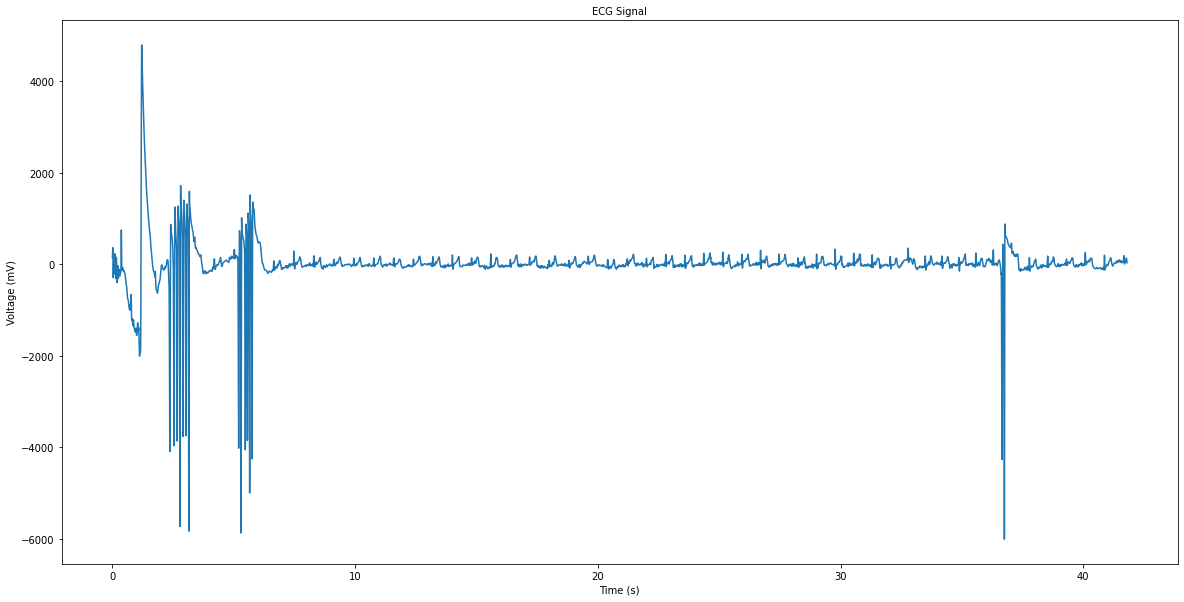

In [43]:
plot_ecg(load_ecg("/home/aateg/workspace/tud/wettbewerb/training/train_ecg_05610.mat"))

/tmp/ipykernel_60627/2662515968.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


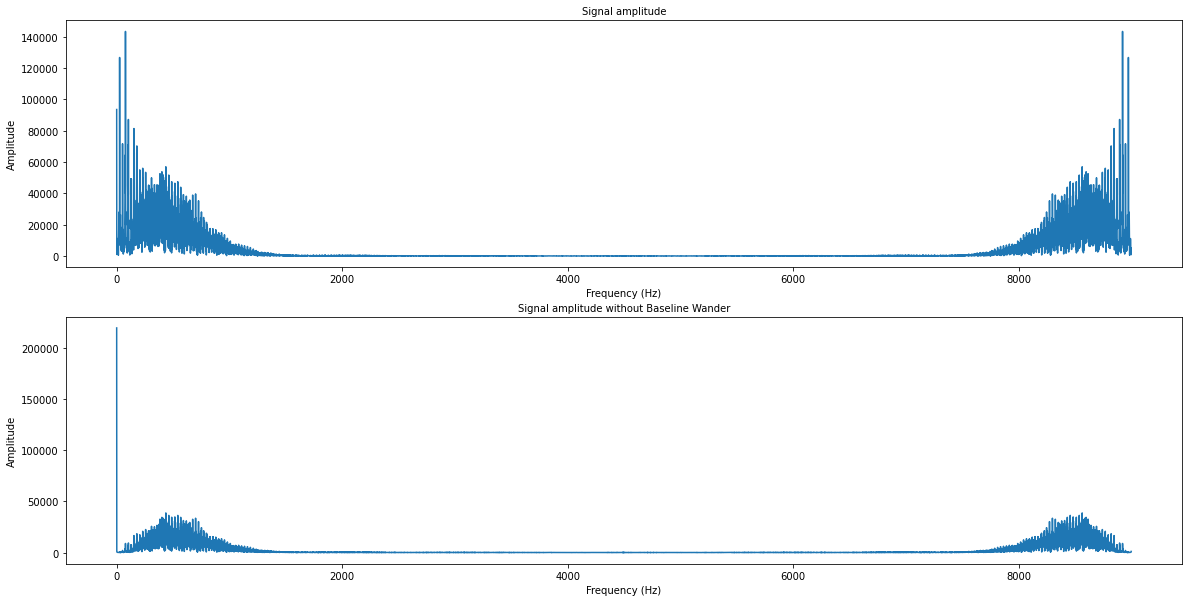

In [20]:
from scipy.fft import rfft, rfftfreq, fft

# Note the extra 'r' at the front
signal = load_ecg("/home/aateg/workspace/tud/wettbewerb/training/train_ecg_00001.mat")
ohne_noise_ecg = remove_baseline_wander(signal, sample_rate=300, cutoff=0.05)




# xf = rfftfreq(N, 1 / SAMPLE_RATE)
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(np.abs(fft(signal)))
axs[0].set_title("Signal amplitude")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Amplitude")

axs[1].plot(np.abs(fft(ohne_noise_ecg)))
axs[1].set_title("Signal amplitude without Baseline Wander")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Amplitude")
fig.show()

In [15]:
fs = 300
T = 1/fs
N = signal.shape[0]
t = np.arange(0, N, T)

In [16]:
t.shape

(2700000,)

In [17]:
signal.shape

(9000,)

In [44]:
from preprocessing import pipeline

In [49]:
from preprocessing.data_processing import normalize, apply_filter, rr_peaks_from_ecg_signal

In [50]:
apply_filter(signal)

array([180.61573871, 247.34388697, 311.61590769, ..., 205.1834746 ,
       196.60843211, 187.91658213])

In [52]:
rr_peaks_from_ecg_signal(apply_filter(signal))

array([0.25])

(9000,)


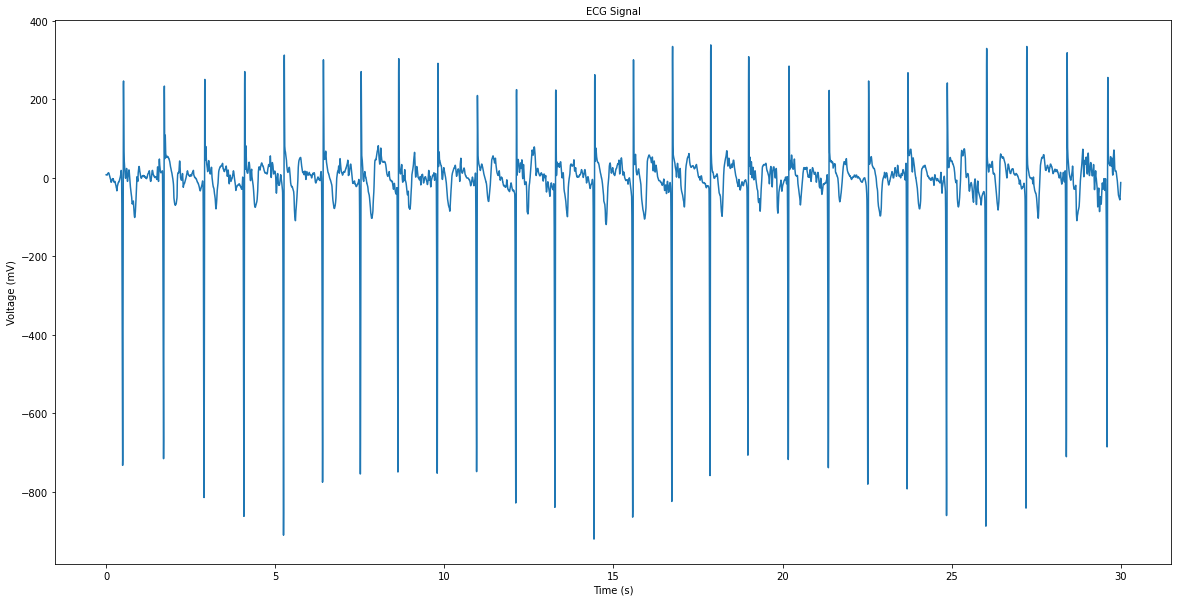

In [65]:
plot_ecg(load_ecg("/home/aateg/workspace/tud/wettbewerb/training/train_ecg_00001.mat"))

(12540,)


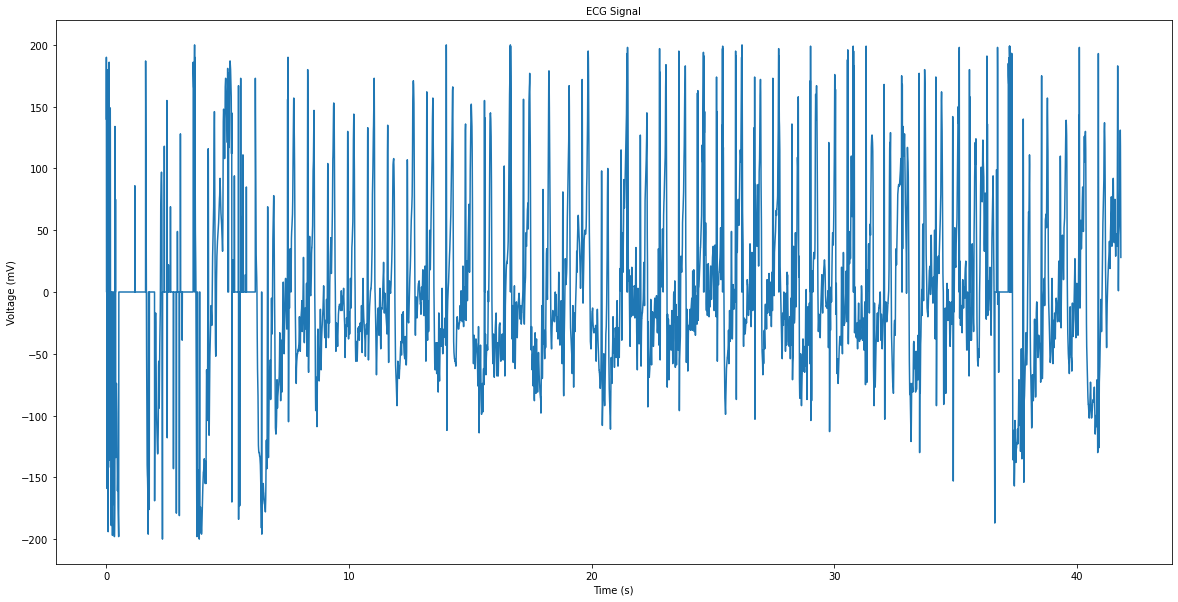

In [60]:
signal = load_ecg("/home/aateg/workspace/tud/wettbewerb/training/train_ecg_05610.mat")
signal[abs(signal) > 200] = 0
plot_ecg(signal)

<AxesSubplot:>

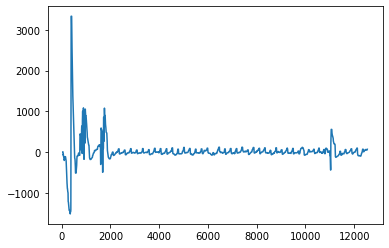

In [75]:
import pandas as pd
d = pd.Series(signal)

d.rolling(50).median().plot()

## Trying to apply some outlier removal

In [68]:
from biosppy.clustering import outliers_dmean

signal = load_ecg("/home/aateg/workspace/tud/wettbewerb/training/train_ecg_05610.mat")
news = outliers_dmean(data = signal)

ValueError: the 'keepdims' parameter is not supported in the pandas implementation of mean()

(12540,)


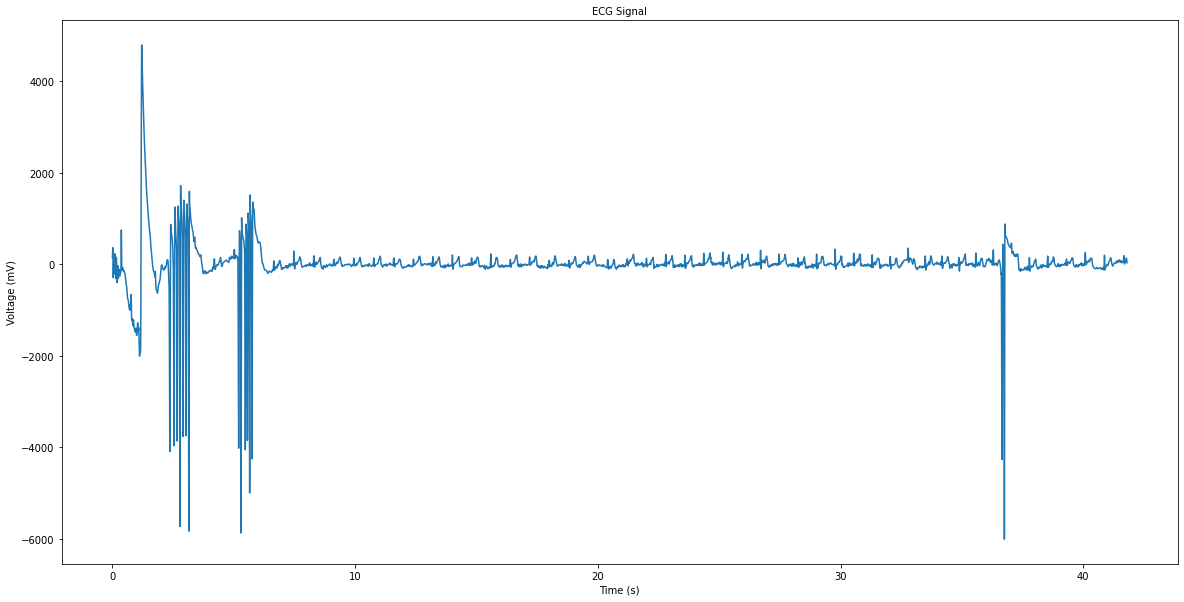

In [66]:
plot_ecg(news)

# Model

In [24]:
from preprocessing.metrics import feature_names

In [21]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

In [23]:
# Read resulting dataframe
df = pd.read_csv("features.csv")
df.head()

,min_rate,avg_rate,std_rate,max_rate,sdnn,nn50,sdsd,rmssd,low_freq_power_perc,high_freq_power_perc,freq_power_ratio,label
0,165.745856,172.304976,3.649955,179.640719,7.488034,0.0,5.409332,6.959510,0.309650,0.000297,1043.553581,N
1,197.368421,215.332249,13.033602,248.962656,15.827769,0.0,6.252907,7.483315,0.196235,0.000080,2452.646909,N
2,158.311346,278.425060,23.324717,297.029703,27.698409,2.0,22.750349,27.510557,0.098087,0.000094,1041.473061,O
3,184.049080,197.929585,5.545482,210.526316,8.768506,0.0,4.775932,7.559289,0.128914,0.000155,831.827235,N
4,262.008734,346.729074,70.040811,451.127820,35.073473,17.0,25.083690,60.280903,0.097419,0.000121,802.359279,O


In [27]:

# X_train, X_test, y_train, y_test = train_test_split(df[feature_names],df[["label"]], train_size=0.8)

model = LGBMClassifier(
    metric="multi_logloss",
    num_leaves=32
)

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# score = f1_score(y_test, y_pred, average="weighted")

scores = cross_val_score(model, df[feature_names],
                        df[["label"]],
                        cv=5,
                        scoring='f1_weighted')
# print("Cross Validation Scores: {}".format(scores))
# print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/lib/python3.

In [30]:
print(f"Score mean: {scores.mean()}")
print(f"Scores: {scores}")

Score mean: 0.7889233528172725
Scores: [0.79288789 0.79842399 0.80575329 0.7899129  0.75763868]


In [31]:

X_train, X_test, y_train, y_test = train_test_split(df[feature_names],df[["label"]], train_size=0.8)

model = LGBMClassifier(
    metric="multi_logloss",
    num_leaves=32
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=['N', 'A', 'O', '~'])

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels=['N', 'A', 'O', '~']))

              precision    recall  f1-score   support

           N       0.85      0.93      0.89       718
           A       0.82      0.63      0.72       115
           O       0.69      0.64      0.67       329
           ~       0.61      0.37      0.46        38

    accuracy                           0.80      1200
   macro avg       0.74      0.64      0.68      1200
weighted avg       0.80      0.80      0.80      1200



In [43]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred, labels=['N', 'A', 'O', '~'])

In [40]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 2.5 MB/s eta 0:00:00 MB/s eta 0:00:01
You should consider upgrading via the '/home/aateg/workspace/tud/wettbewerb/wb-ki-medizin/.venv/bin/python -m pip install --upgrade pip' command.


In [54]:
import seaborn
import matplotlib.pyplot as plt

def plot_confusion_matrix(data, labels, title, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title(f"Confusion matrix for label: {title}")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()

In [42]:
labels = ['N', 'A', 'O', '~']
data = confusion_matrix(y_test, y_pred, labels=labels)
plot_confusion_matrix(data, labels, "multilabel_confusion_matrix.png")

In [56]:
for i in range(len(mcm)):
    plot_confusion_matrix(mcm[i], [labels[i], f"not {labels[i]}"], labels[i], f"confusion_matrix_label_{labels[i]}.png")

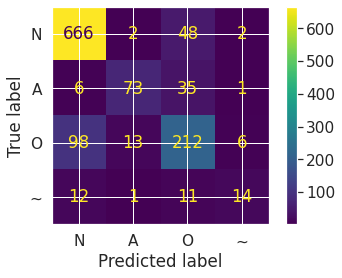

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()